# Clustering cities with more than 100.000 inhabitants based on their infrastructure 

### Applied Data Science Capstone by IBM/Coursera/The Battle of Neighborhoods 

Developed by: Camilo Quiroga 17/04/20

## Table of contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Results](#results)
* [Conclusion](#conclusion)

## 1. Introduction 
### 1.1 Background

Families moving to a new country face many hardships, from understanding the culture, learning the language, ﬁnding a job and ﬁnding a place to live. To ease the migration they would like to ﬁnd a city similar (or dissimilar) to the one they were living in their home country, with a similar or better infrastructure and quality of life. It would be helpful to have a comparison between the most important cities in their home country and they destiny, to ﬁnd out which are similar.

### 1.2 Description of the problem

With so many alternatives and so many variables is easy to get lost and with so much information it’s easy to misunderstand what the data is telling you. It would be great if there was a comparison of the different cities in a country of choice which gives you a general view of each place and it’s pro’s and contras. Here the problem will be for a family to decide a city in Germany to move from a south-american country (Chile) to a European country (Germany), and the family would like to have a priority list of the places which better satisfy their requirements. 

The requirements are: 

* Schools 
* Coffee
* Hospitals 
* Nightlife 
* Playground 
* Shops 
* Entertainment 
* Restaurant


### 1.3 Interest

The ﬁndings of such an analysis would be of interest for families moving between Chile and Germany, and also for companies expanding their businesses to new cities.


## 2.  Data
### 2.1 Data Sources

I fount a list of the cities and they coordinates in Wikidata trough a query for data on cities with over 100.000 population, with labels and coordinates, which you can ﬁnd here: 

https://query.wikidata.org/embed.html#%23LIMIT%2010%0ASELECT%20DISTINCT%20%3Fcity%20%3FcityLabel%20%3Fpopulation%20%3Fpa_s%20%3Fpa_sLabel%20%3Fcoordenadas%20WHERE%20%7B%0A%20%20%3Fcity%20(wdt%3AP31%2Fwdt%3AP279*)%20wd%3AQ515.%0A%20%20%3Fcity%20wdt%3AP1082%20%3Fpopulation.%0A%20%20SERVICE%20wikibase%3Alabel%20%7B%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22.%20%7D%0A%20%20FILTER(%3Fpopulation%20%3E%20100000)%0A%20%20OPTIONAL%20%7B%20%3Fcity%20wdt%3AP17%20%3Fpa_s.%20%7D%0A%20%20OPTIONAL%20%7B%20%3Fcity%20wdt%3AP625%20%3Fcoordenadas.%20%7D%0A%7D%0AORDER%20BY%20DESC(%3Fpopulation)

I obtained the venues for each place using the Foursquare API for each city in both countries. 

To get the venues I created a new python package with a function which uses the foursquare package, then cleans the data and returns a pandas dataframe. Tha package is called foursquareapitools and can be found on its repository in GitHub.

### 2.2 Cleaning of the data

The data downloaded from Wikidata had to be cleaned by splitting the coordinates column into Longitude and Latitude, dropping na values and creating a new dataset with only the cities of Chile and Germay. 

Then I got the venues for each city which was already cleaned by the function in the package I created, as it returns, in a dataframe, Name, City, Country, Latitude, Longitude, Category and Address from Foursquare. When getting the venues I added additional columns for country (country2), city (city2) and search query (query) because I needed that information for the cluster analysis and foursquare returns empty data and differently written names (they are written by users). With the 2 additional columns I could get a proper dataset for the analysis.

After cleaning the data I had 2 Countries, 84 Cities and 31589 venues using Foursquare: 

* 2072 venues in Chile 
* 29517 venues in Germany 
* 346 unique categories




In [1]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
#from project_lib import Project
#project = Project(project_id='3ef43ceb-dbe9-4a5e-afd4-a499b74bc4b6', project_access_token='p-15058a173641e224fb293b039deb9f1431a752bb')
#pc = project.project_context

# @hidden_cell
CLIENT_ID = '0ONCEUND11DYFXHF4LW1GX44W4QZKFW1AU2WQMO2P5HVYTMO' # your Foursquare ID
CLIENT_SECRET = 'SPRNAOPCR0BBYZY3UYUGCOKWLUCPB3KKL3JN4P2VC0FKDE5N' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

Let's install required packages and import libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line to install geopy
from geopy.geocoders import Nominatim# convert an address into latitude and longitude values
from geopy.geocoders import Yandex# convert an address into latitude and longitude values

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library


!pip install foursquare
!pip install git+https://github.com/dacog/foursquare_api_tools.git#egg=foursquare_api_tools
    
#!pip install foursquare
#!pip install git+https://github.com/dacog/foursquare_api_tools.git egg==foursquare_api_tools --upgrade --force-reinstall
#!pip install git+https://github.com/dacog/foursquare_api_tools.git egg=foursquare_api_tools

import foursquare as fs
from foursquare_api_tools import foursquare_api_tools as ft

#some stuff to make it more interactive
import sys
import time
output_stream = sys.stdout
import time

print('Libraries imported.')

Libraries imported.


## Get Data
To get all the cities I used a query on wikipedia data and saved the file on the Project GitHub Repository

In [3]:
## Get city data from github from csv file from data.wikipedia.org query with biggest cities
#url='https://raw.githubusercontent.com/dacog/Coursera_Capstone/master/query%20wikipedia%20biggest%20cities.csv'
url='https://raw.githubusercontent.com/dacog/Coursera_Capstone/master/resources/query%20wikipedia%20biggest%20cities%20with%20coordinates.csv'
df_cities = pd.read_csv(url)
df_cities.head()

,city,cityLabel,population,pa_s,pa_sLabel,coordenadas
0,http://www.wikidata.org/entity/Q8686,Shanghai,23390000,http://www.wikidata.org/entity/Q148,People's Republic of China,Point(121.466666666 31.166666666)
1,http://www.wikidata.org/entity/Q956,Beijing,21710000,http://www.wikidata.org/entity/Q148,People's Republic of China,Point(116.391388888 39.905)
2,http://www.wikidata.org/entity/Q8673,Lagos,21324000,http://www.wikidata.org/entity/Q1033,Nigeria,Point(3.4 6.45)
3,http://www.wikidata.org/entity/Q1490,Tokyo,13784212,http://www.wikidata.org/entity/Q17,Japan,Point(139.77 35.68)
4,http://www.wikidata.org/entity/Q11736,Tianjin,13245000,http://www.wikidata.org/entity/Q148,People's Republic of China,Point(117.205555555 39.146666666)


Let's check the shape of df_cities

In [4]:
print('We have',df_cities.shape[0], 'cities')

We have 2957 cities


### Clean the cities dataset

In [5]:
#rename columns
df_cities.columns=['city data link','City','Population','country data link','Country','Coordinates']
#drop empty rows
df_cities.dropna(how='any',axis=0,inplace=True)
#df = df[pd.notnull(df['Gender'])]
#split coordinates
df_cities[['Longitude','Latitude']] = df_cities['Coordinates'].str.split(' ',expand=True)
#clean coordinates
df_cities['Longitude'] = df_cities['Longitude'].str[6:]
df_cities['Latitude'] = df_cities['Latitude'].str[:-1]
#df[['V','allele']] = df['V'].str.split('-',expand=True)
df_cities=df_cities[pd.notnull(df_cities['Latitude'])]
df_cities=df_cities[pd.notnull(df_cities['Longitude'])]
df_cities.drop_duplicates()
#drop Coordinates as it's not needed anymore
df_cities.drop('Coordinates',axis=1, inplace=True)

df_cities.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude
0,http://www.wikidata.org/entity/Q8686,Shanghai,23390000,http://www.wikidata.org/entity/Q148,People's Republic of China,121.466666666,31.166666666
1,http://www.wikidata.org/entity/Q956,Beijing,21710000,http://www.wikidata.org/entity/Q148,People's Republic of China,116.391388888,39.905
2,http://www.wikidata.org/entity/Q8673,Lagos,21324000,http://www.wikidata.org/entity/Q1033,Nigeria,3.4,6.45
3,http://www.wikidata.org/entity/Q1490,Tokyo,13784212,http://www.wikidata.org/entity/Q17,Japan,139.77,35.68
4,http://www.wikidata.org/entity/Q11736,Tianjin,13245000,http://www.wikidata.org/entity/Q148,People's Republic of China,117.205555555,39.146666666


## Some insights into the dataset

In [6]:
#check number of countries in dataframe
print('There are {} Countries' .format(df_cities['Country'].unique().size))

There are 167 Countries


In [7]:
#check number of cities in dataframe
print('There are {} Cities' .format(df_cities['City'].unique().size))

There are 2509 Cities


### Count the number of cities per country

In [8]:
df_cities.groupby('Country').count()

,city data link,City,Population,country data link,Longitude,Latitude
Country,,,,,,
Afghanistan,8,8,8,8,8,8
Albania,4,4,4,4,4,4
Algeria,5,5,5,5,5,5
Angola,6,6,6,6,6,6
Argentina,27,27,27,27,27,27
Armenia,2,2,2,2,2,2
Australia,15,15,15,15,15,15
Austria,7,7,7,7,7,7
Azerbaijan,3,3,3,3,3,3


We will analize only the cities of Chile and Germany

In [9]:
print('There are {} cities in Chile with more than 100.000 inhabitants' 
      .format(df_cities.loc[df_cities['Country'] == 'Chile'].shape[0]))

There are 8 cities in Chile with more than 100.000 inhabitants


In [10]:
print('There are {} cities in Germany with more than 100.000 inhabitants' 
      .format(df_cities.loc[df_cities['Country'] == 'Germany'].shape[0]))

There are 76 cities in Germany with more than 100.000 inhabitants


We have to check the columns types 

In [11]:
#Check the column types
df_cities.dtypes

city data link       object
City                 object
Population            int64
country data link    object
Country              object
Longitude            object
Latitude             object
dtype: object

Latitude and Longitude Columns have to be floats. let's fix that.

In [12]:
#Latitude and Longitude types are wrong
df_cities['Latitude']=df_cities['Latitude'].astype(float)
df_cities['Longitude']=df_cities['Longitude'].astype(float)
df_cities.dtypes

city data link        object
City                  object
Population             int64
country data link     object
Country               object
Longitude            float64
Latitude             float64
dtype: object

### Let's create a new dataset for the cities in Chile and Germany

In [13]:
#Create a new dataframe and asign Cities from Chile and Germany
df_DeCl=df_cities.loc[df_cities['Country'] == 'Chile']
df_DeCl=df_DeCl.append(df_cities.loc[df_cities['Country'] == 'Germany'])

#let's check the number of countries and cities in the new dataframe

#check number of countries in dataframe
print('There are {} Countries' .format(df_DeCl['Country'].unique().size))

#check number of cities in dataframe
print('There are {} Cities' .format(df_DeCl['City'].unique().size))

There are 2 Countries
There are 84 Cities


We will save this file for future references

In [ ]:
#project.save_data(data=df_DeCl.to_csv(index=False),file_name='df_decl.csv',overwrite=False)  #creates a new file each time

## 3. Methodology

After creating the new dataset with cities form Chile and Germany I plotted the cities on a map using Folium to check if the coordinates were ok.

### 3.1 Venue categories for each city


After cleaning all the data and preparing the ﬁnal datasets, I created a “One Hot encoding” for each category for each city base on the categories Foursquare returned and city2 column I added. I added this column because, for example, for Antofagasta (a city in Chile) there were 4 different ways the users wrote its name, and it was the same for each of the 84 cities. Adding the cities2 column allowed me to have the same city label for each venue. 

After doing the “One Hot encoding” I had a dataset citiesonehot_ with shape (31589, 347), which I grouped by City with the category mean. 

Then I created a new dataframe city_venues_sorted with the most common venues for each city.

### 3.2 Cluster Analysis
 
I used K-Means Cluster Analysis with K=5 and Hierarchical Cluster Analysis with 7 clusters and got similar results, I then plotted which on a Folium Map with Colors for each cluster. 

I created a Dendogram with several linkage methods to see how the cities group. I used 7 clusters with the complete linkage method, you can see into the next lines

## 4. Results

For K-Means Analysis I got the following results:

* K-means for 0 has 58 cities 
* K-means for 1 has 12 cities 
* K-means for 2 has 3 cities 
* K-means for 3 has 4 cities 
* K-means for 4 has 3 cities 

With Hierarchical Clustering with complete Linkage I got, for 7 Clusters: 

* Hierarchical for 0 has 5 cities 
* Hierarchical for 1 has 10 cities 
* Hierarchical for 2 has 58 cities 
* Hierarchical for 3 has 1 cities 
* Hierarchical for 4 has 4 cities 

## 5. Conclusions

In this study I analysed the main cities in 2 countries based on infrastructure (venues) I got from Foursquare API. 

K-Means and Hierarchical Clustering gave similar results, and because of the Dendogram for Hierarchical Cluster with complete linkage I decided for 7 clusters, even if cluster number 3 has only one city: “Mülheim an der Ruh” in Germany. 

These city groups can be very helpful for families searching for a similar city in a new country and for companies looking for similar cities to expand.

# Below the detail of the code:


## Lets create a map with the cities of Germany and Chile

In [14]:
map_world = folium.Map()

# add markers to map
for lat, lng, city in zip(df_DeCl['Latitude'], df_DeCl['Longitude'], df_DeCl['City']):
    label = '{}'.format(city)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_world)  
    
map_world

## Now we have to get the venues for each city.

We are interested in the results for each city for a series of categories, which we will find by using a query

In [ ]:
#We can save the new dataframe for future references

#project.save_data(data=df_DeCl.to_csv(index=False),file_name='df_decl.csv',overwrite=False)  #creates a new file each time

To get the data I developed a package with a function to get the venues around a coordinate and return a dataframe. I used the foursquare package, iterated and cleaned the result and then transformed the output into a dataframe.

You can find the package at https://github.com/dacog/foursquare_api_tools

In [15]:
df_DeCl.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude
1212,http://www.wikidata.org/entity/Q3612,Antofagasta,380695,http://www.wikidata.org/entity/Q298,Chile,-70.400000,-23.633333
1308,http://www.wikidata.org/entity/Q184345,Viña del Mar,334248,http://www.wikidata.org/entity/Q298,Chile,-71.533333,-33.033333
1424,http://www.wikidata.org/entity/Q33986,Valparaíso,296655,http://www.wikidata.org/entity/Q298,Chile,-71.616361,-33.045944
1639,http://www.wikidata.org/entity/Q82128,Temuco,236377,http://www.wikidata.org/entity/Q298,Chile,-72.666667,-38.750000
1724,http://www.wikidata.org/entity/Q4469,Talca,220357,http://www.wikidata.org/entity/Q298,Chile,-71.666667,-35.433333


In [ ]:
# Load Venues

In [16]:
#it takes a while to get all the venues. We can read them here once saved

#uncomment to load venues from github
#df_DeCl_venues=pd.read_csv(project.get_file('venues_decl.csv'))

#uncomment to load venues from github
df_DeCl_venues=pd.read_csv('https://raw.githubusercontent.com/dacog/Coursera_Capstone/master/resources/venues_decl.csv')

df_DeCl_venues.head()

,index,Address,Category,City,Country,Latitude,Longitude,Name,Country2,City2,Query
0,0,NaN,School,NaN,Chile,-23.635031,-70.395411,Escuela República del Ecuador,Chile,Antofagasta,school
1,0,Bolivar 467,School,Antofagasta,Chile,-23.646197,-70.395763,Colegio Adventista de Antofagasta,Chile,Antofagasta,school
2,0,NaN,School,NaN,Chile,-23.647161,-70.393152,Escuela De Conductores Scorpio,Chile,Antofagasta,school
3,0,NaN,School,Antofagasta,Chile,-23.650057,-70.400556,Liceo Marta Narea,Chile,Antofagasta,school
4,0,Uribe,School,Antofagasta,Chile,-23.650438,-70.399704,Escuela de conductores magallanes,Chile,Antofagasta,school


In [31]:
#df_DeCl_venues=venues_ft

### Call foursquare api

Because Foursquare data is done by user some of the fields are/may be missing. Because of that we added the city and country to the for-loop when getting the venues as city2 and country2. We also added the query as a column to get the "main category" in which the one we will get from the api can be grouped.

In [32]:
#create an empty df
venues_ft = pd.DataFrame()
#define queries we want to pass the function. This are the categories we are interested in.
queries=['school','university','hospital','restaurant','coffee','entertainment','shops','playground','nightlife','lodging']

# Construct the client object as instructed in foursquare package
client = fs.Foursquare(client_id=CLIENT_ID, client_secret=CLIENT_SECRET, version=VERSION)

#let's print for how many cities are we going to search for venues
print('I have to look for ',df_DeCl.shape[0],' cities.')
i=0
for i in range(i,df_DeCl.shape[0]):
    lat = df_DeCl.iloc[i,df_DeCl.columns.get_loc('Latitude')]
    long = df_DeCl.iloc[i,df_DeCl.columns.get_loc('Longitude')]
    #print(lat,long)
    try:
        for query in queries:
            new_venues=ft.venues_explore(client,lat=str(lat),lng=str(long),limit=1000, offset=2,query=query)
            #foursquare give names of country and city in original langage and/or user submited of the place. We need the normal ones.
            new_venues['Country2']=df_DeCl.iloc[i,df_DeCl.columns.get_loc('Country')]
            new_venues['City2']=df_DeCl.iloc[i,df_DeCl.columns.get_loc('City')]
            new_venues['Query']=query
            venues_ft=venues_ft.append(new_venues)
            #print('shape %s\r'% venues_ft.shape) #for debug
    except:
        #print('%s\r has no data' % i) #for debug
        pass
    output_stream.write('%s\r' % i)
    output_stream.flush()

#we save the new dataframe as it takes a while to get all the venues.
#project.save_data(data=venues_ft.to_csv(index=False),file_name='venues_decl.csv',overwrite=True) #creates a new file each time

#use this in case you excecuted the for loop to get the venues from foursquare
df_DeCl_venues=venues_ft

#we save the new dataframe as it takes a while to get all the venues.
#project.save_data(data=venues_ft.to_csv(index=False),file_name=str(time.time())+'_'+'venues_decl.csv',overwrite=True) #creates a new file each time

#print('I got {} venues with {} columns' .format(venues_ft.shape[0],venues_ft.shape[1]))

I have to look for  84  cities.


Let's check the number of venues and some insights

In [33]:
print('We got {} venues using Foursquare' .format(df_DeCl_venues.shape[0]))

We got 32982 venues using Foursquare


In [34]:
print('There are {} venues in Chile' 
      .format(df_DeCl_venues.loc[df_DeCl_venues['Country2'] == 'Chile'].shape[0]))

print('There are {} venues in Germany' 
      .format(df_DeCl_venues.loc[df_DeCl_venues['Country2'] == 'Germany'].shape[0]))

There are 1651 venues in Chile
There are 31331 venues in Germany


In [35]:
print('There are {} uniques categories.'.format(len(df_DeCl_venues['Category'].unique())))

There are 365 uniques categories.


In [36]:
df_DeCl_venues.head(5)

,index,Name,City,Latitude,Longitude,Category,Address,Country,Country2,City2,Query
0,0,Escuela República del Ecuador,,-23.635031,-70.395411,School,,Chile,Chile,Antofagasta,school
1,0,Colegio Adventista de Antofagasta,Antofagasta,-23.646197,-70.395763,School,Bolivar 467,Chile,Chile,Antofagasta,school
2,0,Escuela De Conductores Scorpio,,-23.647161,-70.393152,School,,Chile,Chile,Antofagasta,school
3,0,Liceo Marta Narea,Antofagasta,-23.650057,-70.400556,School,,Chile,Chile,Antofagasta,school
4,0,Escuela de conductores magallanes,Antofagasta,-23.650438,-70.399704,School,Uribe,Chile,Chile,Antofagasta,school


Let's check of all the venues have at least one value

In [37]:
df_DeCl_venues.loc[df_DeCl_venues['Category'].isna()]

,index,Name,City,Latitude,Longitude,Category,Address,Country,Country2,City2,Query


## One Hot encoding of the categories

In [38]:
# one hot encoding
cities_onehot = pd.get_dummies(df_DeCl_venues[['Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
cities_onehot['City'] = df_DeCl_venues['City2'] 

# move neighborhood column to the first column
fixed_columns = [cities_onehot.columns[-1]] + list(cities_onehot.columns[:-1])
cities_onehot = cities_onehot[fixed_columns]

cities_onehot.head()

,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace

In [39]:
#And let's examine the new dataframe size.
cities_onehot.shape

(32982, 366)

In [40]:
#cities_onehot.isna().any().shape

#cities_onehot.loc[:, cities_onehot.isna().any()]

In [41]:
#lets group by city

cities_grouped = cities_onehot.groupby('City').mean().reset_index()
cities_grouped.head()

,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace

In [42]:
num_top_venues = 5

for city in cities_grouped['City']:
    print("----"+city+"----")
    temp = cities_grouped[cities_grouped['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aachen----
                venue  freq
0                Café  0.11
1         Supermarket  0.07
2              Bakery  0.07
3      Clothing Store  0.04
4  Italian Restaurant  0.04


----Antofagasta----
                  venue  freq
0                  Café  0.05
1         Shopping Mall  0.05
2            Restaurant  0.05
3      Department Store  0.04
4  Fast Food Restaurant  0.04


----Augsburg----
               venue  freq
0               Café  0.12
1                Bar  0.03
2        Supermarket  0.03
3  German Restaurant  0.03
4   Lottery Retailer  0.03


----Berlin----
                   venue  freq
0                   Café  0.09
1            Coffee Shop  0.06
2  General Entertainment  0.05
3                    Bar  0.04
4        Language School  0.03


----Bielefeld----
                      venue  freq
0                      Café  0.09
1            Clothing Store  0.06
2                       Bar  0.06
3               Supermarket  0.04
4  Mediterranean Restaurant  0.04


----B

4  Mobile Phone Shop  0.03


----Ulm----
                venue  freq
0                Café  0.14
1         Supermarket  0.04
2                 Bar  0.04
3      Clothing Store  0.04
4  Italian Restaurant  0.03


----Valparaíso----
         venue  freq
0         Café  0.12
1   Restaurant  0.08
2   University  0.07
3  Coffee Shop  0.06
4     Hospital  0.05


----Viña del Mar----
                  venue  freq
0            University  0.19
1              Hospital  0.07
2                  Café  0.06
3  Fast Food Restaurant  0.05
4              Pharmacy  0.05


----Wiesbaden----
               venue  freq
0               Café  0.15
1        Supermarket  0.06
2  German Restaurant  0.05
3                Bar  0.04
4        Coffee Shop  0.04


----Wolfsburg----
             venue  freq
0       University  0.36
1  Language School  0.14
2   Driving School  0.14
3      High School  0.14
4    Middle School  0.14


----Wuppertal----
             venue  freq
0           School  0.30
1      High School 

In [43]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [44]:
#num_top_venues = len(df_DeCl_venues['Category'].unique())

num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted = pd.DataFrame(columns=columns)
city_venues_sorted['City'] = cities_grouped['City']

for ind in np.arange(cities_grouped.shape[0]):
    city_venues_sorted.iloc[ind, 1:] = return_most_common_venues(cities_grouped.iloc[ind, :], num_top_venues)

city_venues_sorted.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
0,Aachen,Café,Supermarket,Bakery,Italian Restaurant,Clothing Store,Coffee Shop,University,Drugstore,German Restaurant,School,General Entertainment,Restaurant,Fast Food Restaurant,Vietnamese Restaurant,Furniture / Home Store,Lawyer,Hospital,Organic Grocery,Department Store,Mediterranean Restaurant
1,Antofagasta,Café,Shopping Mall,Restaurant,Fast Food Restaurant,Department Store,University,Gastropub,Playground,Chinese Restaurant,General Entertainment,Clothing Store,Pharmacy,Bar,School,Coffee Shop,Pizza Place,Sandwich Place,Bakery,Steakhouse,Cosmetics Shop
2,Augsburg,Café,German Restaurant,Supermarket,Bar,Italian Restaurant,Lottery Retailer,Clothing Store,Turkish Restaurant,Lawyer,Coffee Shop,School,Brewery,Burger Joint,Gastropub,Pub,Drugstore,Bakery,Restaurant,Optical Shop,Lounge
3,Berlin,Café,Coffee Shop,General Entertainment,Bar,Language School,Restaurant,School,Hotel Bar,Supermarket,Clothing Store,Drugstore,German Restaurant,Playground,Medical Center,Hospital,Italian Restaurant,Cocktail Bar,Nightclub,Elementary School,Breakfast Spot
4,Bielefeld,Café,Clothing Store,Bar,Supermarket,Mediterranean Restaurant,Coffee Shop,Playground,Restaurant,Hospital,School,Nightclub,German Restaurant,Greek Restaurant,Burger Joint,Drugstore,Mobile Phone Shop,Pizza Place,Italian Restaurant,General Entertainment,Asian Restaurant


## Cluster cities

In [45]:
#df_DeCl['Population'].shape
#cities_grouped_clustering.head(5)

In [46]:
# set number of clusters
kclusters = 5

cities_grouped_clustering = cities_grouped.drop('City', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 2, 0, 2, 0, 0])

In [47]:
# add clustering labels
city_venues_sorted.insert(0, 'Cluster Labels K-Means', kmeans.labels_)

city_merged = df_DeCl

# merge to add latitude/longitude for each neighborhood
city_merged = city_merged.join(city_venues_sorted.set_index('City'), on='City')

city_merged.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1212,http://www.wikidata.org/entity/Q3612,Antofagasta,380695,http://www.wikidata.org/entity/Q298,Chile,-70.400000,-23.633333,0.0,Café,Shopping Mall,Restaurant,Fast Food Restaurant,Department Store,University,Gastropub,Playground,Chinese Restaurant,General Entertainment,Clothing Store,Pharmacy,Bar,School,Coffee Shop,Pizza Place,Sandwich Place,Bakery,Steakhouse,Cosmetics Shop
1308,http://www.wikidata.org/entity/Q184345,Viña del Mar,334248,http://www.wikidata.org/entity/Q298,Chile,-71.533333,-33.033333,0.0,University,Hospital,Café,Pharmacy,Fast Food Restaurant,Sushi Restaurant,Restaurant,High School,School,Sandwich Place,Grocery Store,Supermarket,Shopping Mall,General Entertainment,Seafood Restaurant,Food,Japanese Restaurant,Liquor Store,Chinese Restaurant,Donut Shop
1424,http://www.wikidata.org/entity/Q33986,Valparaíso,296655,http://www.wikidata.org/entity/Q298,Chile,-71.616361,-33.045944,0.0,Café,Restaurant,University,Coffee Shop,Hospital,Seafood Restaurant,Pharmacy,High School,Pizza Place,School,Grocery Store,General Entertainment,Sushi Restaurant,Italian Restaurant,Department Store,Supermarket,Fast Food Restaurant,Liquor Store,South American Restaurant,Sandwich Place
1639,http://www.wikidata.org/entity/Q82128,Temuco,236377,http://www.wikidata.org/entity/Q298,Chile,-72.666667,-38.750000,3.0,High School,Nursery School,School,Yoga Studio,Emergency Room,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Doctor's Office,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
1724,http://www.wikidata.org/entity/Q4469,Talca,220357,http://www.wikidata.org/entity/Q298,Chile,-71.666667,-35.433333,0.0,Café,Restaurant,Coffee Shop,High School,Pharmacy,Playground,University,School,Department Store,Hot Dog Joint,Sushi Restaurant,Breakfast Spot,Hospital,Pizza Place,Grocery Store,Shopping Mall,Sandwich Place,Pub,Electronics Store,Fast Food Restaurant


In [48]:
city_merged['Cluster Labels K-Means'].unique()

array([ 0.,  3.,  2.,  4., nan,  1.])

In [49]:
city_merged.loc[city_merged['Cluster Labels K-Means'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1775,http://www.wikidata.org/entity/Q2838,Oberhausen,211382,http://www.wikidata.org/entity/Q183,Germany,6.850000,51.550000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2117,http://www.wikidata.org/entity/Q2938,Leverkusen,163113,http://www.wikidata.org/entity/Q183,Germany,6.983333,51.033333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2651,http://www.wikidata.org/entity/Q3069,Bottrop,117409,http://www.wikidata.org/entity/Q183,Germany,6.922778,51.524722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2868,http://www.wikidata.org/entity/Q3200,Salzgitter,104614,http://www.wikidata.org/entity/Q183,Germany,10.405849,52.153657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
city_merged=city_merged[np.isfinite(city_merged['Cluster Labels K-Means'])]

In [51]:
city_merged.loc[city_merged['Cluster Labels K-Means'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue


Finally, let's visualize the resulting clusters

In [52]:
# create map
map_clusters = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged['Latitude'], city_merged['Longitude'], city_merged['City'], city_merged['Cluster Labels K-Means']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine Clusters

In [53]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 0, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1212,Antofagasta,-70.400000,-23.633333,0.0,Café,Shopping Mall,Restaurant,Fast Food Restaurant,Department Store,University,Gastropub,Playground,Chinese Restaurant,General Entertainment,Clothing Store,Pharmacy,Bar,School,Coffee Shop,Pizza Place,Sandwich Place,Bakery,Steakhouse,Cosmetics Shop
1308,Viña del Mar,-71.533333,-33.033333,0.0,University,Hospital,Café,Pharmacy,Fast Food Restaurant,Sushi Restaurant,Restaurant,High School,School,Sandwich Place,Grocery Store,Supermarket,Shopping Mall,General Entertainment,Seafood Restaurant,Food,Japanese Restaurant,Liquor Store,Chinese Restaurant,Donut Shop
1424,Valparaíso,-71.616361,-33.045944,0.0,Café,Restaurant,University,Coffee Shop,Hospital,Seafood Restaurant,Pharmacy,High School,Pizza Place,School,Grocery Store,General Entertainment,Sushi Restaurant,Italian Restaurant,Department Store,Supermarket,Fast Food Restaurant,Liquor Store,South American Restaurant,Sandwich Place
1724,Talca,-71.666667,-35.433333,0.0,Café,Restaurant,Coffee Shop,High School,Pharmacy,Playground,University,School,Department Store,Hot Dog Joint,Sushi Restaurant,Breakfast Spot,Hospital,Pizza Place,Grocery Store,Shopping Mall,Sandwich Place,Pub,Electronics Store,Fast Food Restaurant
274,Berlin,13.383333,52.516667,0.0,Café,Coffee Shop,General Entertainment,Bar,Language School,Restaurant,School,Hotel Bar,Supermarket,Clothing Store,Drugstore,German Restaurant,Playground,Medical Center,Hospital,Italian Restaurant,Cocktail Bar,Nightclub,Elementary School,Breakfast Spot
501,Hamburg,10.000000,53.550000,0.0,Café,Coffee Shop,Bar,School,Restaurant,Cocktail Bar,University,German Restaurant,Language School,Supermarket,Shopping Mall,Drugstore,Italian Restaurant,Hotel Bar,Clothing Store,Tea Room,General Entertainment,Burger Joint,French Restaurant,Vegetarian / Vegan Restaurant
578,Munich,11.575500,48.137194,0.0,Café,Hospital,Language School,Bar,Cocktail Bar,University,Bavarian Restaurant,German Restaurant,Supermarket,Drugstore,Coffee Shop,Restaurant,Italian Restaurant,School,Clothing Store,Playground,High School,Department Store,Gourmet Shop,General Entertainment
677,Cologne,6.957778,50.942222,0.0,Café,Supermarket,Coffee Shop,Pub,Bar,Italian Restaurant,German Restaurant,Clothing Store,School,General Entertainment,Brewery,Drugstore,Restaurant,Bakery,Cocktail Bar,High School,Hospital,Gastropub,Sushi Restaurant,University
820,Frankfurt,8.679722,50.113611,0.0,Café,Bar,Coffee Shop,Supermarket,Clothing Store,Restaurant,Language School,School,German Restaurant,Drugstore,Hospital,Italian Restaurant,Cocktail Bar,Gastropub,Wine Bar,General Entertainment,Nightclub,Burger Joint,University,High School
895,Stuttgart,9.177500,48.776111,0.0,Café,Bar,German Restaurant,School,Coffee Shop,Supermarket,Italian Restaurant,Restaurant,Hospital,Nightclub,Clothing Store,University,Cocktail Bar,Drugstore,Sushi Restaurant,Lounge,Shopping Mall,High School,General Entertainment,Wine Bar


In [54]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 1, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
2606,Recklinghausen,7.200000,51.616667,1.0,School,High School,English Restaurant,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,Yoga Studio,Doner Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair
2693,Reutlingen,9.216667,48.483333,1.0,School,Driving School,English Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,Yoga Studio,Convenience Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant
2769,Remscheid,7.200000,51.183333,1.0,School,English Restaurant,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,Yoga Studio,Convenience Store,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant


In [55]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 3, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1639,Temuco,-72.666667,-38.75000,3.0,High School,Nursery School,School,Yoga Studio,Emergency Room,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Empanada Restaurant,Doctor's Office,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space
2173,Herne,7.218970,51.54258,3.0,Driving School,High School,School,English Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,Yoga Studio,Doner Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair
2563,Pforzheim,8.716667,48.90000,3.0,School,High School,Driving School,English Restaurant,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,Yoga Studio,Doner Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair


In [56]:
city_merged.loc[city_merged['Cluster Labels K-Means'] == 4, 
                     city_merged.columns[[1] + list(range(5, city_merged.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels K-Means,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue,15th Most Common Venue,16th Most Common Venue,17th Most Common Venue,18th Most Common Venue,19th Most Common Venue,20th Most Common Venue
1908,Iquique,-70.166667,-20.216667,4.0,School,University,High School,Yoga Studio,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Doner Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop
2390,Ingolstadt,11.426111,48.763611,4.0,University,Language School,School,Yoga Studio,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,Doner Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop
2557,Wolfsburg,10.787222,52.423056,4.0,University,Language School,Driving School,Middle School,High School,School,Emergency Room,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Yoga Studio,Empanada Restaurant,Doner Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service
2939,Cottbus,14.334167,51.760556,4.0,University,School,High School,Yoga Studio,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Doner Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop


## Now lets cluster not with Foursquare categories but our own queries

In [57]:
df_DeCl_venues.groupby('City2').count()

,index,Name,City,Latitude,Longitude,Category,Address,Country,Country2,Query
City2,,,,,,,,,,
Aachen,548,548,548,548,548,548,548,548,548,548
Antofagasta,367,367,367,367,367,367,367,367,367,367
Augsburg,587,587,587,587,587,587,587,587,587,587
Berlin,1047,1047,1047,1047,1047,1047,1047,1047,1047,1047
Bielefeld,463,463,463,463,463,463,463,463,463,463
Bochum,31,31,31,31,31,31,31,31,31,31
Bonn,740,740,740,740,740,740,740,740,740,740
Bremen,37,37,37,37,37,37,37,37,37,37
Bremerhaven,235,235,235,235,235,235,235,235,235,235


In [58]:
df_DeCl_venues.head()

,index,Name,City,Latitude,Longitude,Category,Address,Country,Country2,City2,Query
0,0,Escuela República del Ecuador,,-23.635031,-70.395411,School,,Chile,Chile,Antofagasta,school
1,0,Colegio Adventista de Antofagasta,Antofagasta,-23.646197,-70.395763,School,Bolivar 467,Chile,Chile,Antofagasta,school
2,0,Escuela De Conductores Scorpio,,-23.647161,-70.393152,School,,Chile,Chile,Antofagasta,school
3,0,Liceo Marta Narea,Antofagasta,-23.650057,-70.400556,School,,Chile,Chile,Antofagasta,school
4,0,Escuela de conductores magallanes,Antofagasta,-23.650438,-70.399704,School,Uribe,Chile,Chile,Antofagasta,school


In [59]:
# one hot encoding
cities_onehot_query = pd.get_dummies(df_DeCl_venues[['Query']], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_query['City'] = df_DeCl_venues['City2'] 

# move city column to the first column
fixed_columns = [cities_onehot_query.columns[-1]] + list(cities_onehot_query.columns[:-1])
cities_onehot_query = cities_onehot_query[fixed_columns]

cities_onehot_query.head()

,City,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,Antofagasta,0,0,0,0,0,0,1,0,0
1,Antofagasta,0,0,0,0,0,0,1,0,0
2,Antofagasta,0,0,0,0,0,0,1,0,0
3,Antofagasta,0,0,0,0,0,0,1,0,0
4,Antofagasta,0,0,0,0,0,0,1,0,0


In [60]:
#lets group by city

cities_grouped_query = cities_onehot_query.groupby('City').mean().reset_index()
cities_grouped_query.head()

,City,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,Aachen,0.166058,0.020073,0.012774,0.000000,0.000000,0.364964,0.041971,0.363139,0.031022
1,Antofagasta,0.057221,0.029973,0.013624,0.095368,0.035422,0.297003,0.046322,0.389646,0.035422
2,Augsburg,0.120954,0.015332,0.008518,0.168654,0.008518,0.301533,0.032368,0.332198,0.011925
3,Berlin,0.191022,0.065903,0.037249,0.191022,0.023878,0.191022,0.102197,0.191022,0.006686
4,Bielefeld,0.127430,0.015119,0.028078,0.136069,0.032397,0.282937,0.036717,0.330454,0.010799


In [61]:
num_top_venues = 5

for city in cities_grouped_query['City']:
    print("----"+city+"----")
    temp = cities_grouped_query[cities_grouped_query['City'] == city].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Aachen----
        venue  freq
0  restaurant  0.36
1       shops  0.36
2      coffee  0.17
3      school  0.04
4  university  0.03


----Antofagasta----
        venue  freq
0       shops  0.39
1  restaurant  0.30
2   nightlife  0.10
3      coffee  0.06
4      school  0.05


----Augsburg----
        venue  freq
0       shops  0.33
1  restaurant  0.30
2   nightlife  0.17
3      coffee  0.12
4      school  0.03


----Berlin----
        venue  freq
0      coffee  0.19
1   nightlife  0.19
2  restaurant  0.19
3       shops  0.19
4      school  0.10


----Bielefeld----
        venue  freq
0       shops  0.33
1  restaurant  0.28
2   nightlife  0.14
3      coffee  0.13
4      school  0.04


----Bochum----
           venue  freq
0         school   1.0
1         coffee   0.0
2  entertainment   0.0
3       hospital   0.0
4      nightlife   0.0


----Bonn----
        venue  freq
0  restaurant  0.27
1       shops  0.25
2   nightlife  0.18
3      coffee  0.17
4      school  0.06


----Bremen----


4      school  0.02


----Ulm----
        venue  freq
0       shops  0.36
1  restaurant  0.25
2   nightlife  0.16
3      coffee  0.12
4      school  0.05


----Valparaíso----
        venue  freq
0  restaurant  0.36
1       shops  0.22
2      coffee  0.19
3  university  0.08
4      school  0.07


----Viña del Mar----
        venue  freq
0  restaurant  0.31
1       shops  0.21
2  university  0.20
3      school  0.11
4    hospital  0.08


----Wiesbaden----
        venue  freq
0  restaurant  0.33
1       shops  0.27
2      coffee  0.16
3   nightlife  0.13
4      school  0.07


----Wolfsburg----
           venue  freq
0         school  0.64
1     university  0.36
2         coffee  0.00
3  entertainment  0.00
4       hospital  0.00


----Wuppertal----
           venue  freq
0         school  0.85
1     university  0.15
2         coffee  0.00
3  entertainment  0.00
4       hospital  0.00


----Würzburg----
           venue  freq
0     restaurant  0.38
1          shops  0.35
2         coffee  

In [62]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['City']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
city_venues_sorted_query = pd.DataFrame(columns=columns)
city_venues_sorted_query['City'] = cities_grouped_query['City']

for ind in np.arange(cities_grouped_query.shape[0]):
    city_venues_sorted_query.iloc[ind, 1:] = return_most_common_venues(cities_grouped_query.iloc[ind, :], num_top_venues)

city_venues_sorted_query.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Aachen,restaurant,shops,coffee,school,university
1,Antofagasta,shops,restaurant,nightlife,coffee,school
2,Augsburg,shops,restaurant,nightlife,coffee,school
3,Berlin,shops,restaurant,nightlife,coffee,school
4,Bielefeld,shops,restaurant,nightlife,coffee,school


In [63]:
# set number of clusters
kclusters = 5

cities_grouped_clustering_query = cities_grouped_query.drop('City', 1)

# run k-means clustering
kmeans_q = KMeans(n_clusters=kclusters, random_state=0).fit(cities_grouped_clustering_query)

# check cluster labels generated for each row in the dataframe
kmeans_q.labels_[0:10] 

array([0, 0, 3, 3, 0, 1, 3, 1, 4, 0])

In [64]:
# add clustering labels
city_venues_sorted_query.insert(0, 'Cluster Labels K-Means Query', kmeans.labels_)

city_merged_query = df_DeCl

# merge to add latitude/longitude for each neighborhood
city_merged_query = city_merged_query.join(city_venues_sorted_query.set_index('City'), on='City')

city_merged_query.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means Query,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1212,http://www.wikidata.org/entity/Q3612,Antofagasta,380695,http://www.wikidata.org/entity/Q298,Chile,-70.400000,-23.633333,0.0,shops,restaurant,nightlife,coffee,school
1308,http://www.wikidata.org/entity/Q184345,Viña del Mar,334248,http://www.wikidata.org/entity/Q298,Chile,-71.533333,-33.033333,0.0,restaurant,shops,university,school,hospital
1424,http://www.wikidata.org/entity/Q33986,Valparaíso,296655,http://www.wikidata.org/entity/Q298,Chile,-71.616361,-33.045944,0.0,restaurant,shops,coffee,university,school
1639,http://www.wikidata.org/entity/Q82128,Temuco,236377,http://www.wikidata.org/entity/Q298,Chile,-72.666667,-38.750000,3.0,school,university,shops,restaurant,playground
1724,http://www.wikidata.org/entity/Q4469,Talca,220357,http://www.wikidata.org/entity/Q298,Chile,-71.666667,-35.433333,0.0,restaurant,shops,coffee,school,nightlife


In [65]:
city_merged_query['Cluster Labels K-Means Query'].unique()

array([ 0.,  3.,  2.,  4., nan,  1.])

In [66]:
city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means Query,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1775,http://www.wikidata.org/entity/Q2838,Oberhausen,211382,http://www.wikidata.org/entity/Q183,Germany,6.850000,51.550000,NaN,NaN,NaN,NaN,NaN,NaN
2117,http://www.wikidata.org/entity/Q2938,Leverkusen,163113,http://www.wikidata.org/entity/Q183,Germany,6.983333,51.033333,NaN,NaN,NaN,NaN,NaN,NaN
2651,http://www.wikidata.org/entity/Q3069,Bottrop,117409,http://www.wikidata.org/entity/Q183,Germany,6.922778,51.524722,NaN,NaN,NaN,NaN,NaN,NaN
2868,http://www.wikidata.org/entity/Q3200,Salzgitter,104614,http://www.wikidata.org/entity/Q183,Germany,10.405849,52.153657,NaN,NaN,NaN,NaN,NaN,NaN


In [67]:
city_merged_query=city_merged_query[np.isfinite(city_merged_query['Cluster Labels K-Means Query'])]

In [68]:
city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'].isnull()]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels K-Means Query,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


Finally, let's visualize the resulting clusters

In [69]:
# create map
map_clusters_q = folium.Map()

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged_query['Latitude'], city_merged_query['Longitude'], city_merged_query['City'], city_merged_query['Cluster Labels K-Means Query']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)],
        fill=True,
        fill_color=rainbow[int(cluster)],
        fill_opacity=0.7).add_to(map_clusters_q)
       
map_clusters_q

## Hierarchical cluster analysis

In [70]:
X = cities_grouped.drop('City', axis=1)
X.head()

,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Mall,Outlet Store,Pakistani Restaurant,Palace,Pape

In [71]:
X.shape

(80, 365)

In [72]:
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))  
plt.title("Cities Dendograms")  
dend = shc.dendrogram(shc.linkage(X, method='ward'))  
plt.show

<function matplotlib.pyplot.show(*args, **kw)>

This looks interesting. Let's apply hierarchical clustering with different linkage

<Figure size 432x288 with 0 Axes>

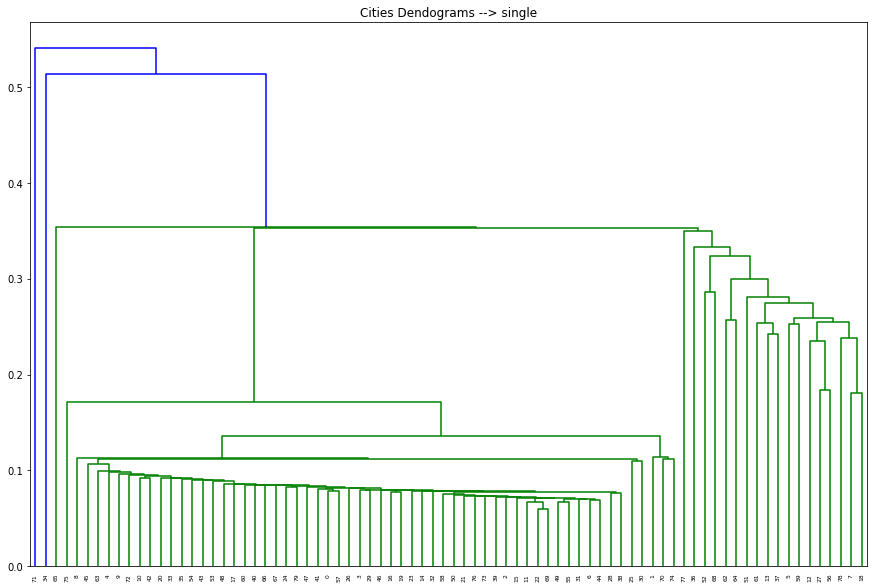

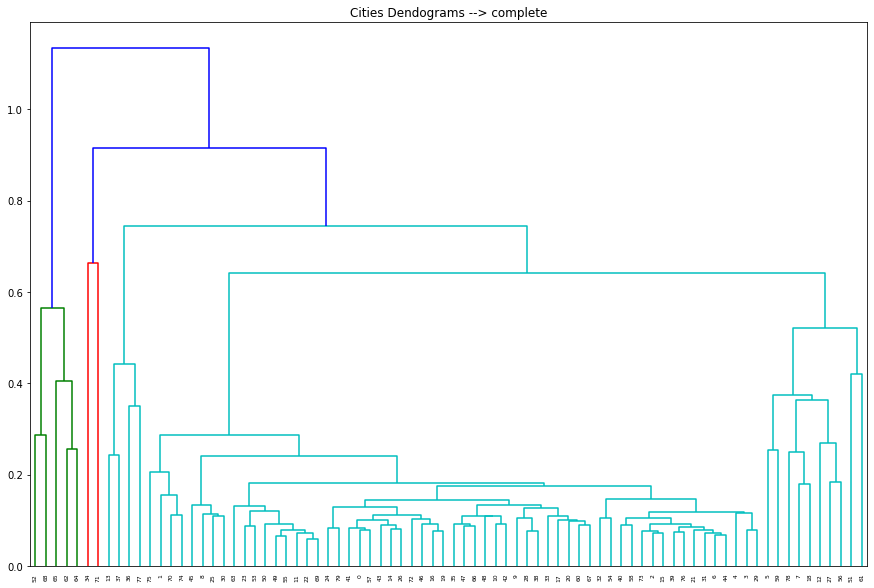

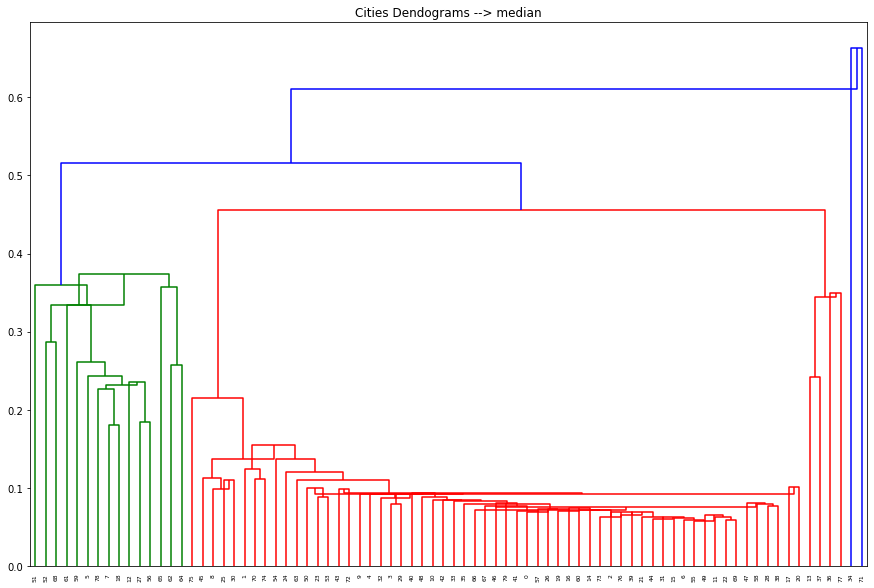

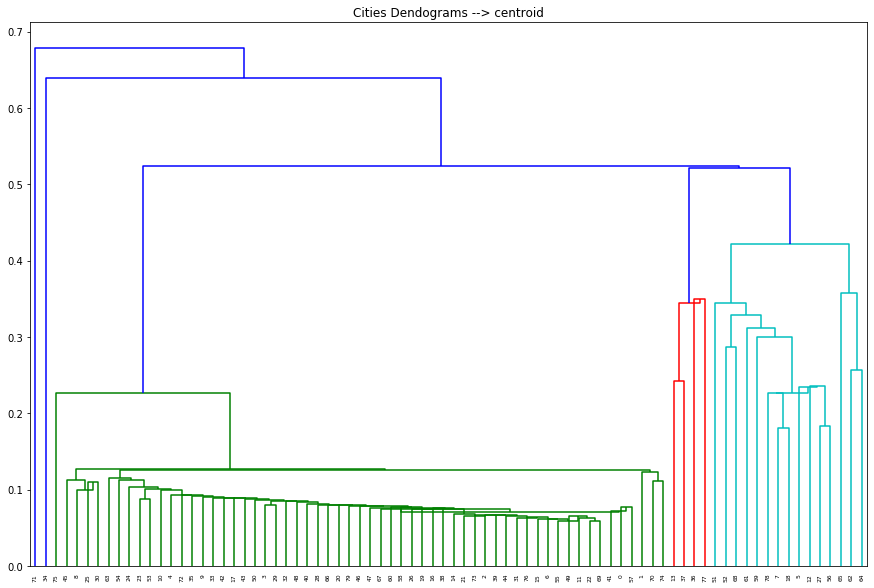

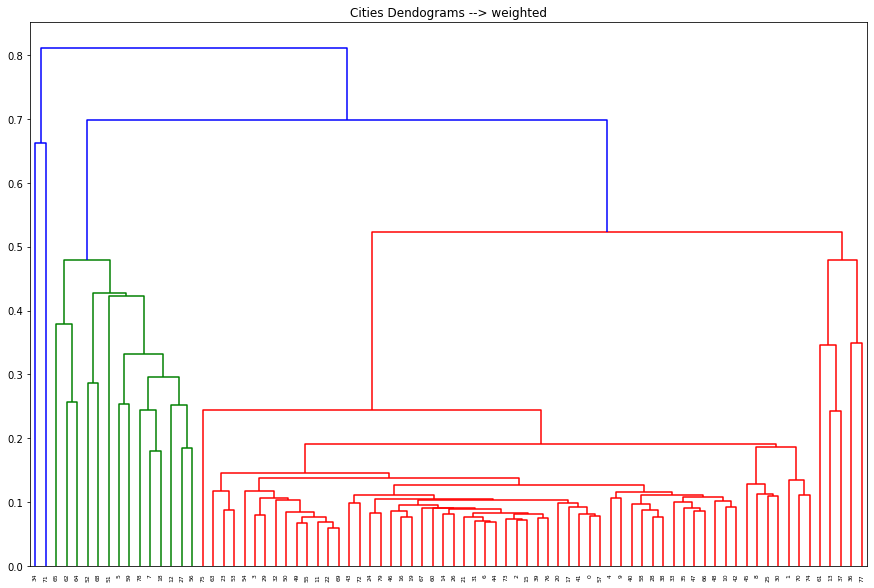

In [73]:
#fig, axes23 = plt.subplots(2, 3)
fig = plt.figure()
methods=['single', 'complete','median','centroid','weighted']
for method, num in zip(methods, range(0,len(methods))):
    plt.figure(figsize=(15, 10))  
    plt.title("Cities Dendograms --> "+str(method))
    dend = shc.dendrogram(shc.linkage(X, method=method))
    plt.show()


## We will use 7 clusters based on weighted hierarchical clustering plot

In [74]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='complete')  
cluster.fit(X)   


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=7,
                        pooling_func='deprecated')

In [75]:
print(cluster.labels_)

[2 2 2 2 2 0 2 0 2 2 2 2 0 1 2 2 2 2 0 2 2 2 2 2 2 2 2 0 2 2 2 2 2 2 4 2 1
 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 6 2 2 2 0 2 2 0 2 0 3 2 3 3 2 2 6 2 2 5 2 2
 2 2 2 1 0 2]


In [76]:
city_venues_sorted_h=cities_grouped[:]
city_venues_sorted_h.insert(0, 'Cluster Labels Hierarchical', cluster.labels_)

In [77]:
city_venues_sorted_h.head()

,Cluster Labels Hierarchical,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Mall,Outlet Store

Let's add coordinates to the dataset again to plot

In [78]:
city_merged_h = df_DeCl

# merge to add latitude/longitude for each neighborhood
city_merged_h = city_merged_h.join(city_venues_sorted_h.set_index('City'), on='City')
#clean nan values
city_merged_h=city_merged_h[np.isfinite(city_merged_h['Cluster Labels Hierarchical'])]
city_merged_h.head()

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair

In [79]:
# create map
map_clusters_h8 = folium.Map()

# set color scheme for the clusters
x = np.arange(9)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(city_merged_h['Latitude'], city_merged_h['Longitude'], city_merged_h['City'], city_merged_h['Cluster Labels Hierarchical']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-2],
        fill=True,
        fill_color=rainbow[int(cluster)-2],
        fill_opacity=0.7).add_to(map_clusters_h8)
       
map_clusters_h8

## Let's compare

In [80]:
i=0
for i in range(0,5):
    print('K-means for {} has {} cities' .format(i,city_merged.loc[city_merged['Cluster Labels K-Means'] == i].shape[0]))

K-means for 0 has 59 cities
K-means for 1 has 3 cities
K-means for 2 has 11 cities
K-means for 3 has 3 cities
K-means for 4 has 4 cities


In [81]:
i=0
for i in range(0,5):
    print('K-means for {} has {} cities' .format(i,city_merged_query.loc[city_merged_query['Cluster Labels K-Means Query'] == i].shape[0]))
    
    

K-means for 0 has 59 cities
K-means for 1 has 3 cities
K-means for 2 has 11 cities
K-means for 3 has 3 cities
K-means for 4 has 4 cities


In [82]:
i=0
for i in range(0,5):
    print('Hierarchical for {} has {} cities' .format(i,city_venues_sorted_h.loc[city_venues_sorted_h['Cluster Labels Hierarchical'] == i].shape[0]))
    
    

Hierarchical for 0 has 10 cities
Hierarchical for 1 has 4 cities
Hierarchical for 2 has 59 cities
Hierarchical for 3 has 3 cities
Hierarchical for 4 has 1 cities


# Look into a particular cluster

In [83]:
city_merged_h.head(3)

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair

in city_merged_h we have columns for Cluster Labels Hierarchical 5, Cluster Labels Hierarchical and Cluster Labels K-Means

In [84]:
#cluster_type='Cluster Labels K-Means'
cluster_type='Cluster Labels Hierarchical'


city_merged_h.loc[city_merged_h[cluster_type] == 3, 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outle

# Search for a particular city

In [85]:
search_city='Valparaíso'

city_merged_h.loc[city_merged_h['City'] == search_city, 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outle

In [86]:
city_merged_h.loc[city_merged_h.apply(lambda row: row.astype(str).str.contains('Zoo').any(), axis=1), 
                     city_merged_h.columns[[1] + list(range(5, city_merged_h.shape[1]))]]

,City,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outle

In [87]:
city_merged_h[city_merged_h['Cluster Labels Hierarchical'] == 2.0]

,city data link,City,Population,country data link,Country,Longitude,Latitude,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair

## Most frequent venues for each cluster

**let's check the venues for each cluster using foursquare categories for the analysis**

In [88]:
city_venues_sorted_h.head()

,Cluster Labels Hierarchical,City,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Mall,Outlet Store

In [89]:
# one hot encoding

city_venues_sorted_ho = city_venues_sorted_h.drop('City',axis=1)
city_venues_sorted_ho = city_venues_sorted_ho.drop('Cluster Labels Hierarchical', axis=1)
cities_onehot_h = pd.get_dummies(city_venues_sorted_ho[9:], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_h['Cluster Labels Hierarchical'] = city_venues_sorted_h['Cluster Labels Hierarchical']

# move city column to the first column
fixed_columns = [cities_onehot_h.columns[-1]] + list(cities_onehot_h.columns[:-1])
cities_onehot_h = cities_onehot_h[fixed_columns]

cities_onehot_h.head()

,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Mall,Outlet Store,Paki

In [90]:
cities_grouped_h = cities_onehot_h.groupby('Cluster Labels Hierarchical').mean().reset_index()
cities_grouped_h.head()

,Cluster Labels Hierarchical,ATM,Accessories Store,Adult Boutique,Adult Education Center,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Apple Wine Pub,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Bath House,Bavarian Restaurant,Beach,Beach Bar,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Big Box Store,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Borek Place,Botanical Garden,Boutique,Bowling Alley,Brasserie,Bratwurst Joint,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Business Service,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Churrascaria,Cigkofte Place,Clothing Store,Cocktail Bar,Coffee Roaster,Coffee Shop,College Academic Building,College Administrative Building,College Arts Building,College Cafeteria,College Classroom,College Engineering Building,College Library,College Math Building,College Technology Building,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Construction & Landscaping,Convenience Store,Cooking School,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currywurst Joint,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Diner,Discount Store,Distillery,Dive Bar,Dive Shop,Doctor's Office,Doner Restaurant,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Emergency Room,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Service,Event Space,Fabric Shop,Fair,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Film Studio,Financial or Legal Service,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Franconian Restaurant,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Halal Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hobby Shop,Home Service,Hookah Bar,Hospital,Hospital Ward,Hot Dog Joint,Hotel,Hotel Bar,Hungarian Restaurant,Hunting Supply,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Inn,Insurance Office,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Kumpir Restaurant,Kurdish Restaurant,Language School,Latin American Restaurant,Laundromat,Lawyer,Leather Goods Store,Lebanese Restaurant,Library,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lottery Retailer,Lounge,Luggage Store,Malay Restaurant,Manti Place,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Medical School,Medical Supply Store,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Middle School,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Mongolian Restaurant,Monument / Landmark,Moroccan Restaurant,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Non-Profit,Noodle House,Notary,Nursery School,Office,Optical Shop,Organic Grocery,Other Nightlife,Other Repair Shop,Outdoor Event Space,Outdoor Supply Store,Outlet Mall,Outlet Store,Paki

In [91]:
num_top_venues = 5

for city in cities_grouped_h['Cluster Labels Hierarchical']:
    print("----"+str(city)+"----")
    temp = cities_grouped_h[cities_grouped_h['Cluster Labels Hierarchical'] == city].T.reset_index()
    #print(temp)
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
             venue  freq
0           School  0.43
1      High School  0.17
2     Music School  0.11
3  Language School  0.07
4   Driving School  0.06


----1----
             venue  freq
0       University  0.45
1           School  0.26
2      High School  0.12
3  Language School  0.11
4    Middle School  0.04


----2----
               venue  freq
0               Café  0.13
1        Supermarket  0.06
2     Clothing Store  0.03
3  German Restaurant  0.03
4         Restaurant  0.03


----3----
            venue  freq
0          School  0.84
1  Driving School  0.10
2     High School  0.06
3    Noodle House  0.00
4      Non-Profit  0.00


----4----
            venue  freq
0  Driving School  0.55
1     High School  0.36
2          School  0.09
3    Noodle House  0.00
4      Non-Profit  0.00


----5----
            venue  freq
0     High School  0.67
1  Nursery School  0.22
2          School  0.11
3   Middle School  0.00
4       Mini Golf  0.00


----6----
             venue  freq

**it's really hard to see the differences because foursquare returns to many categories**

**Let's do the same with our queries instead of the categories**

In [92]:
Xq = cities_grouped_query.drop('City', axis=1)
Xq.head()

,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,0.166058,0.020073,0.012774,0.000000,0.000000,0.364964,0.041971,0.363139,0.031022
1,0.057221,0.029973,0.013624,0.095368,0.035422,0.297003,0.046322,0.389646,0.035422
2,0.120954,0.015332,0.008518,0.168654,0.008518,0.301533,0.032368,0.332198,0.011925
3,0.191022,0.065903,0.037249,0.191022,0.023878,0.191022,0.102197,0.191022,0.006686
4,0.127430,0.015119,0.028078,0.136069,0.032397,0.282937,0.036717,0.330454,0.010799


In [93]:
cities_grouped_query.head()

,City,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,Aachen,0.166058,0.020073,0.012774,0.000000,0.000000,0.364964,0.041971,0.363139,0.031022
1,Antofagasta,0.057221,0.029973,0.013624,0.095368,0.035422,0.297003,0.046322,0.389646,0.035422
2,Augsburg,0.120954,0.015332,0.008518,0.168654,0.008518,0.301533,0.032368,0.332198,0.011925
3,Berlin,0.191022,0.065903,0.037249,0.191022,0.023878,0.191022,0.102197,0.191022,0.006686
4,Bielefeld,0.127430,0.015119,0.028078,0.136069,0.032397,0.282937,0.036717,0.330454,0.010799


In [94]:
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=7, affinity='euclidean', linkage='complete')  
cluster.fit(Xq)   


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='complete', memory=None, n_clusters=7,
                        pooling_func='deprecated')

In [95]:
city_venues_sorted_hq=cities_grouped_query[:]
city_venues_sorted_hq.insert(0, 'Cluster Labels Hierarchical', cluster.labels_)
city_venues_sorted_hq=city_venues_sorted_hq.drop('City',axis=1)

In [96]:
city_venues_sorted_hq.head()

,Cluster Labels Hierarchical,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops,university
0,0,0.166058,0.020073,0.012774,0.000000,0.000000,0.364964,0.041971,0.363139,0.031022
1,0,0.057221,0.029973,0.013624,0.095368,0.035422,0.297003,0.046322,0.389646,0.035422
2,0,0.120954,0.015332,0.008518,0.168654,0.008518,0.301533,0.032368,0.332198,0.011925
3,1,0.191022,0.065903,0.037249,0.191022,0.023878,0.191022,0.102197,0.191022,0.006686
4,0,0.127430,0.015119,0.028078,0.136069,0.032397,0.282937,0.036717,0.330454,0.010799


In [97]:
# one hot encoding

#city_venues_sorted_hq = cities_grouped_query.drop('City',axis=1)
city_venues_sorted_hq1 = city_venues_sorted_hq.drop('Cluster Labels Hierarchical', axis=1)
#city_venues_sorted_hq1 = city_venues_sorted_hq1.drop('City', axis=1)
cities_onehot_hq = pd.get_dummies(city_venues_sorted_hq[9:], prefix="", prefix_sep="")

# add city column back to dataframe
cities_onehot_hq['Cluster Labels Hierarchical'] = city_venues_sorted_hq['Cluster Labels Hierarchical']
#print(cities_onehot_hq.head())
# move city column to the first column
fixed_columns = [cities_onehot_hq.columns[-1]] + list(cities_onehot_hq.columns[:-1])
cities_onehot_hq = cities_onehot_hq[fixed_columns]

cities_onehot_hq.head()

,university,Cluster Labels Hierarchical,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops
9,0.023438,0,0.117188,0.007812,0.010937,0.107813,0.076563,0.307812,0.035937,0.312500
10,0.011038,0,0.094923,0.015453,0.011038,0.103753,0.011038,0.302428,0.050773,0.399558
11,0.013815,1,0.212540,0.024442,0.015940,0.212540,0.005313,0.212540,0.090329,0.212540
12,0.000000,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
13,0.562500,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.437500,0.000000


In [98]:
cities_grouped_hq = cities_onehot_hq.groupby('Cluster Labels Hierarchical').mean().reset_index()
cities_grouped_hq.head()

,Cluster Labels Hierarchical,university,coffee,entertainment,hospital,nightlife,playground,restaurant,school,shops
0,0,0.019988,0.131698,0.018863,0.020048,0.099589,0.012470,0.304816,0.042791,0.349737
1,1,0.017314,0.202336,0.017206,0.017978,0.209122,0.014088,0.220917,0.080122,0.220917
2,2,0.410863,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.589137,0.000000
3,3,0.011027,0.050532,0.035830,0.015011,0.000000,0.000000,0.203053,0.040431,0.644117
4,4,0.006203,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.993797,0.000000


In [99]:
num_top_venues = 3

for city in cities_grouped_hq['Cluster Labels Hierarchical']:
    print("----"+str(city)+"----")
    temp = cities_grouped_hq[cities_grouped_hq['Cluster Labels Hierarchical'] == city].T.reset_index()
    #print(temp)
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----0----
        venue  freq
0       shops  0.35
1  restaurant  0.30
2      coffee  0.13


----1----
        venue  freq
0  restaurant  0.22
1       shops  0.22
2   nightlife  0.21


----2----
        venue  freq
0      school  0.59
1  university  0.41
2      coffee  0.00


----3----
        venue  freq
0       shops  0.64
1  restaurant  0.20
2      coffee  0.05


----4----
        venue  freq
0      school  0.99
1  university  0.01
2      coffee  0.00


----5----
        venue  freq
0  restaurant  0.37
1       shops  0.24
2      coffee  0.14


----6----
        venue  freq
0      school  0.82
1  university  0.18
2      coffee  0.00




Now we can better see the differences between the clustes. 

**Cluster 0**
venue  freq
0      school  0.98
1  university  0.02



**Cluster 1**
        venue  freq
0  restaurant  0.31
1       shops  0.28
2   nightlife  0.15


**Cluster 2**
        venue  freq
0  restaurant  0.23
1       shops  0.23
2   nightlife  0.21


**Cluster 3**
        venue  freq
0       shops  0.40
1  restaurant  0.32
2      coffee  0.13


**Cluster 4**
        venue  freq
0       shops  0.65
1  restaurant  0.21
2      coffee  0.05


**Cluster 5**
        venue  freq
0  restaurant  0.30
1  university  0.20
2       shops  0.18


**Cluster 6**
        venue  freq
0      school  0.64
1  university  0.36
